In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
T = 20
N = 200
D = 32   # obs dim
H = 128
x = tf.placeholder(dtype=tf.float32, shape=(T, N, D))
x

<tf.Tensor 'Placeholder:0' shape=(20, 200, 32) dtype=float32>

In [4]:
gru = tf.contrib.cudnn_rnn.CudnnGRU(num_layers=1, num_units=128)

In [34]:
init = np.zeros([1, 10, N, H])
init.shape

(1, 10, 200, 128)

In [35]:
s0 = tuple(init)

In [36]:
s0[0].shape

(10, 200, 128)

## With bulid

In [16]:
gru.build(input_shape=(T, N, D))
gru.call(x, initial_state=init)

(<tf.Tensor 'CudnnRNN_6:0' shape=(20, 200, 32) dtype=float32>,
 (<tf.Tensor 'CudnnRNN_6:1' shape=(200, 128) dtype=float32>,))

In [17]:
gru.call(x)

(<tf.Tensor 'CudnnRNN_7:0' shape=(20, 200, 128) dtype=float32>,
 (<tf.Tensor 'CudnnRNN_7:1' shape=(1, 200, 128) dtype=float32>,))

## Without build

In [9]:
gru_ = tf.contrib.cudnn_rnn.CudnnGRU(num_layers=1, num_units=128)

In [10]:
T = 20
N = 200
D = 32   # obs dim
H = 128
x_ = tf.placeholder(dtype=tf.float32, shape=(T, N, D))

In [18]:
gru_(x_)

(<tf.Tensor 'cudnn_gru_2/CudnnRNN_1:0' shape=(20, 200, 128) dtype=float32>,
 (<tf.Tensor 'cudnn_gru_2/CudnnRNN_1:1' shape=(1, 200, 128) dtype=float32>,))

In [50]:
s0 = tf.placeholder(shape=(1, N, H), dtype=tf.float32)

In [51]:
gru_.call(x_, initial_state=(s0,))

(<tf.Tensor 'CudnnRNN_10:0' shape=(20, 200, 128) dtype=float32>,
 (<tf.Tensor 'CudnnRNN_10:1' shape=(1, 200, 128) dtype=float32>,))

In [56]:
s1 = tf.zeros([3,4])
tf.expand_dims(s0, 0)

<tf.Tensor 'ExpandDims_4:0' shape=(1, 1, 200, 128) dtype=float32>

In [58]:
tf.transpose(x_, (1, 0, 2))

<tf.Tensor 'transpose_3:0' shape=(200, 20, 32) dtype=float32>

In [59]:
x_

<tf.Tensor 'Placeholder_1:0' shape=(20, 200, 32) dtype=float32>

In [60]:
x_[0]

<tf.Tensor 'strided_slice_11:0' shape=(200, 32) dtype=float32>

## data pipeline

In [47]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for SAC agents.
    """

    def __init__(self, obs_dim, act_dim, size, h_size, seq_length, flag="single", normalize=False):
        self.flag = flag
        self.normalize = normalize
        self.sequence_length = seq_length
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        size += seq_length  # in case index is out of range
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.hidden_buf = np.zeros([size, h_size], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size, 1], dtype=np.float32)
        self.done_buf = np.zeros([size, 1], dtype=np.float32)
        self.target_done_ratio = 0

    def store(self, obs, s_t_0, act, rew, done):
        self.obs1_buf[self.ptr] = obs / 10 if self.normalize else obs
        self.hidden_buf[self.ptr] = s_t_0
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size  # 1%20=1 2%20=2 21%20=1
        self.size = min(self.size + 1, self.max_size)  # use self.size to control sample range
        self.target_done_ratio = np.sum(self.done_buf) / self.size

    def sample_batch(self, batch_size=32):
        """
        :param batch_size:
        :return: s a r s' d
        """
        while 1:
            idxs_c = np.empty([batch_size, self.sequence_length])  # N T+1

            # for i in range(batch_size):
            end = False
            while not end:
                ind = np.random.randint(0, self.size - 5)  # random sample a starting point in current buffer
                idxs = np.arange(ind, ind + self.sequence_length)  # extend seq from starting point
                # 0000000 or 0000010 is valid   sum(done) <= 1
                is_valid_pos = True if sum(self.done_buf[idxs]) == 0 else \
                    (((self.sequence_length - np.where(self.done_buf[idxs] == 1)[0][0]) == 2) and
                     (sum(self.done_buf[idxs]) == 1))

                end = True if is_valid_pos else False

            idxs_c[i] = idxs

            np.random.shuffle(idxs_c)
            idxs = idxs_c.astype(int)
            # print(self.target_done_ratio, np.sum(self.done_buf[idxs]) / batch_size)
            data = dict(obs1=self.obs1_buf[idxs],
                        s_t_0=self.hidden_buf[idxs][:, 0, :],  # slide N T H to N H
                        acts=self.acts_buf[idxs],
                        rews=self.rews_buf[idxs],
                        done=self.done_buf[idxs])
            yield data

In [48]:
replay_buffer = ReplayBuffer(obs_dim=64,
                                 act_dim=4,
                                 size=int(1e4),
                                 h_size=128,
                                 seq_length=20,
                                 flag="seq",
                                 normalize=False)

In [49]:
for _ in range(int(1e4)):
    replay_buffer.store(np.random.random([1, 64]), np.random.random([1, 128]), np.random.random([1, 4]), 0, 0)

In [50]:
ds = tf.data.Dataset.from_generator(replay_buffer.sample_batch, output_types=tf.float32)

In [51]:
ds.batch(32)

<BatchDataset shapes: <unknown>, types: tf.float32>

In [54]:
dataset = tf.data.Dataset.range(10)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
sess = tf.Session()
for i in range(100):
  value = sess.run(next_element)
  print(value)

0
1
2
3
4
5
6
7
8
9


OutOfRangeError: End of sequence
	 [[node IteratorGetNext_6 (defined at <ipython-input-54-f75211e63125>:3)  = IteratorGetNext[output_shapes=[[]], output_types=[DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_6)]]

Caused by op 'IteratorGetNext_6', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-f75211e63125>", line 3, in <module>
    next_element = iterator.get_next()
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 421, in get_next
    name=name)), self._output_types,
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 2069, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/gu/project/env_3_6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext_6 (defined at <ipython-input-54-f75211e63125>:3)  = IteratorGetNext[output_shapes=[[]], output_types=[DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_6)]]


# Model Loss

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
%matplotlib inline

In [129]:
loss = np.load("model_loss_1.npy")
# loss = np.load("modelloss3.npy")

In [130]:
loss.shape

(150, 29, 17)

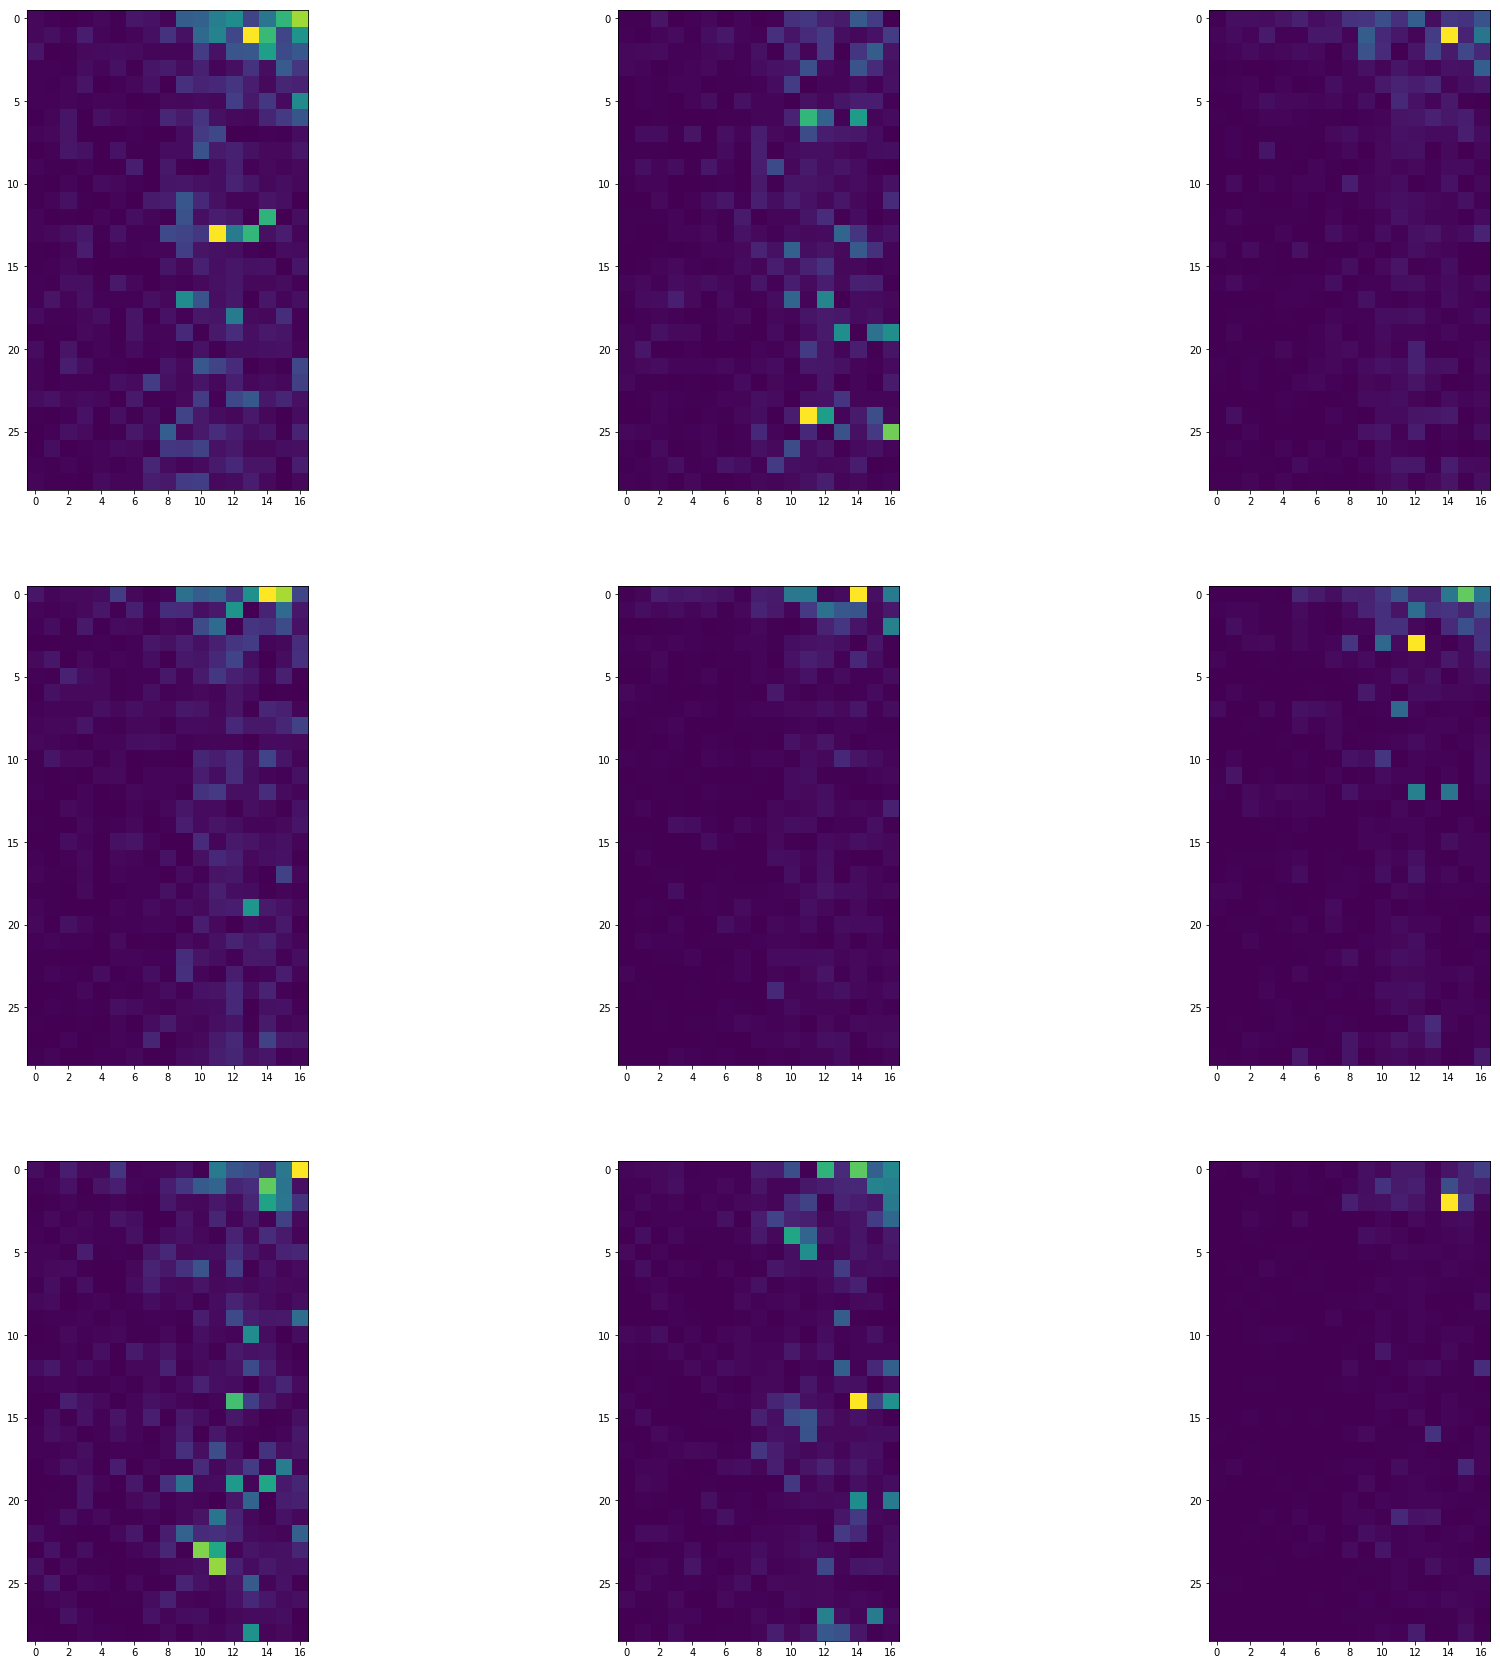

In [131]:
rc['figure.figsize'] = [30, 30]
plt.subplot(331)
plt.imshow(loss[0])
plt.subplot(332)
plt.imshow(loss[1])
plt.subplot(333)
plt.imshow(loss[2])
plt.subplot(334)
plt.imshow(loss[3])
plt.subplot(335)
plt.imshow(loss[4])
plt.subplot(336)
plt.imshow(loss[5])
plt.subplot(337)
plt.imshow(loss[6])
plt.subplot(338)
plt.imshow(loss[7])
plt.subplot(339)
plt.imshow(loss[8])

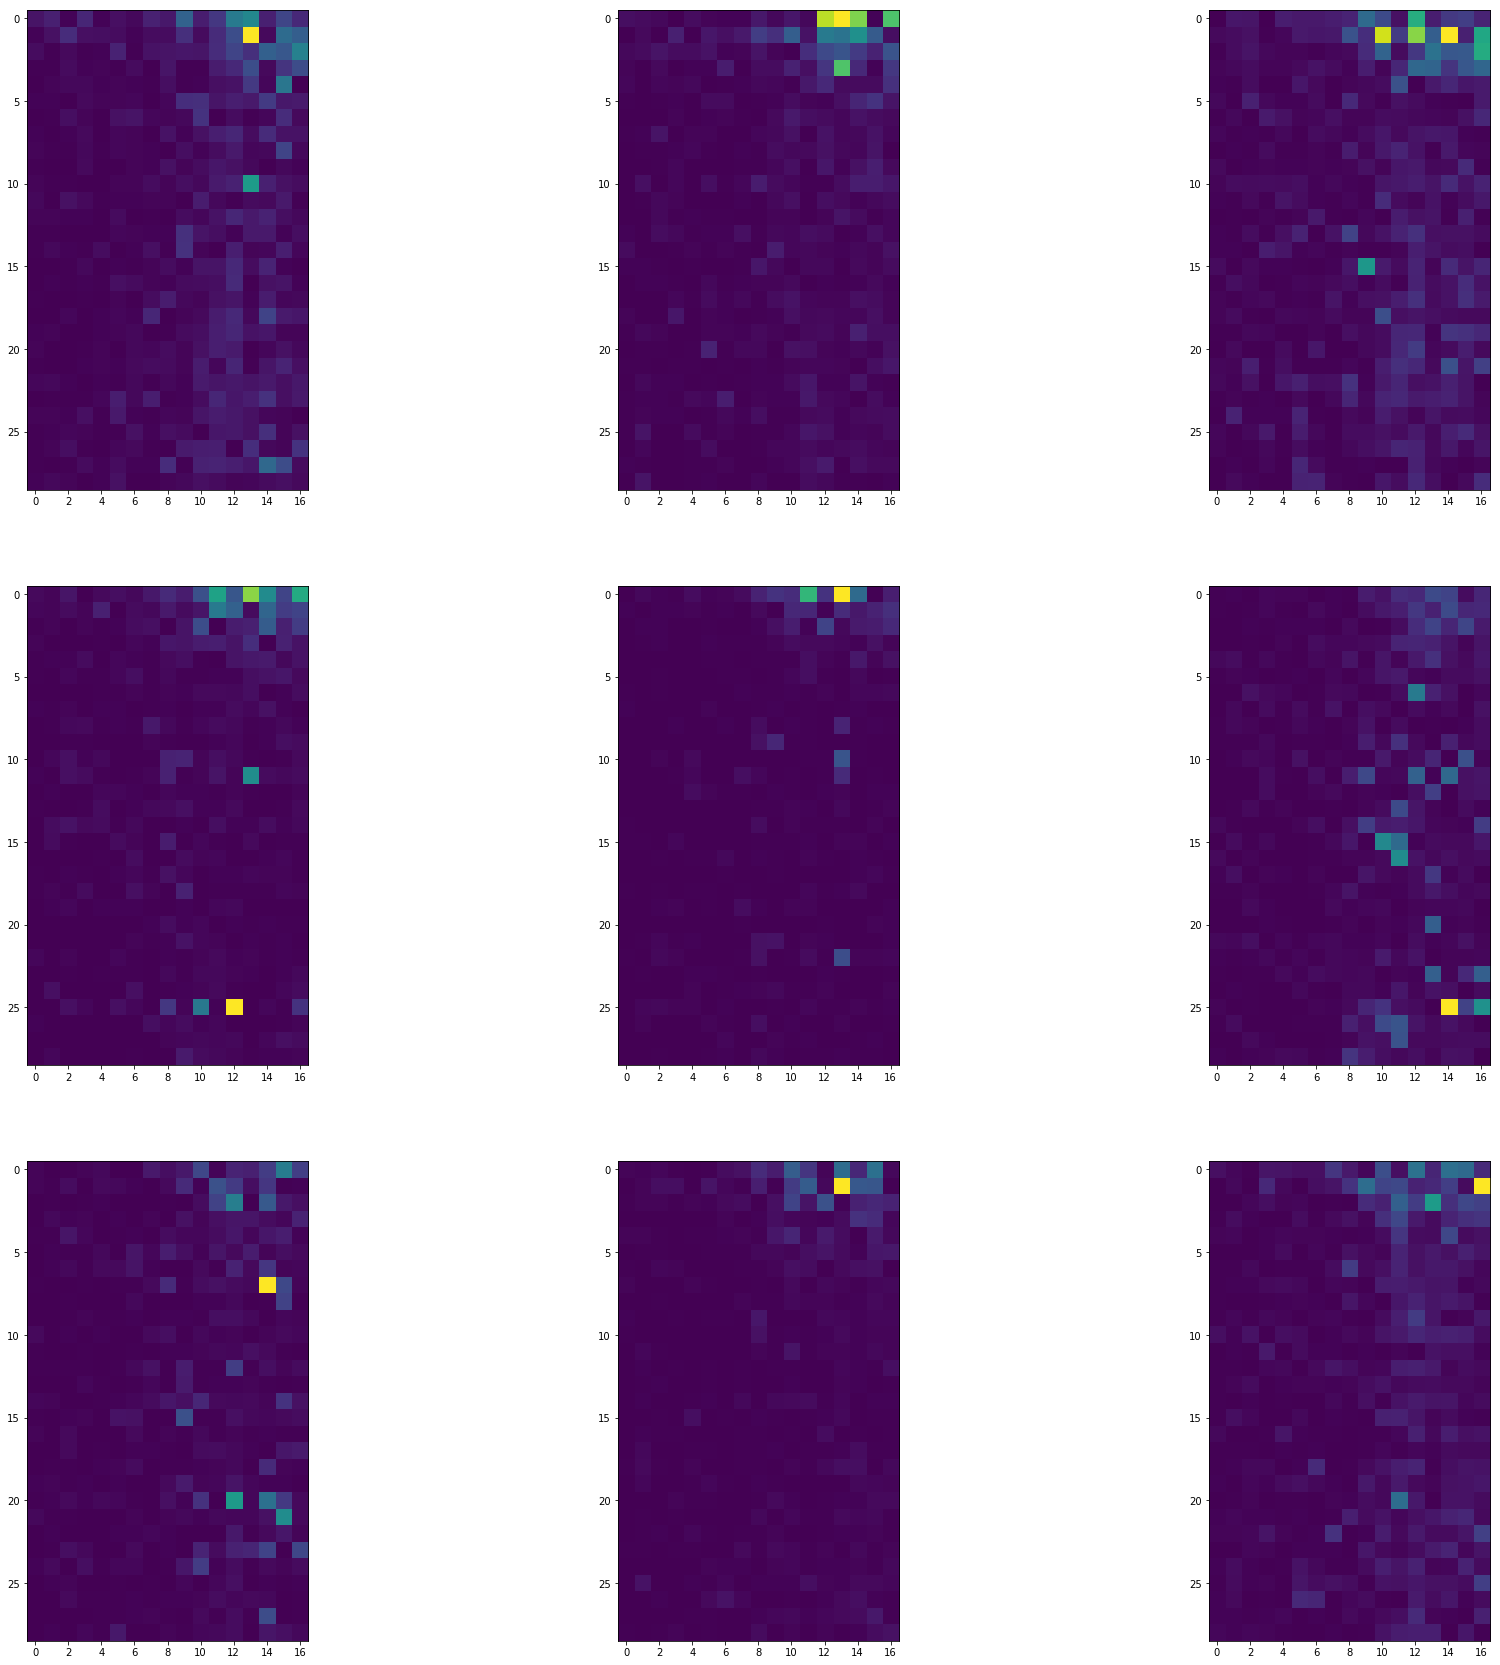

In [132]:
rc['figure.figsize'] = [30, 30]
plt.subplot(331)
plt.imshow(loss[9])
plt.subplot(332)
plt.imshow(loss[10])
plt.subplot(333)
plt.imshow(loss[11])
plt.subplot(334)
plt.imshow(loss[13])
plt.subplot(335)
plt.imshow(loss[14])
plt.subplot(336)
plt.imshow(loss[15])
plt.subplot(337)
plt.imshow(loss[16])
plt.subplot(338)
plt.imshow(loss[17])
plt.subplot(339)
plt.imshow(loss[18])

In [133]:
loss.shape

(150, 29, 17)

In [134]:
loss.max()

10.014447

(29, 17)

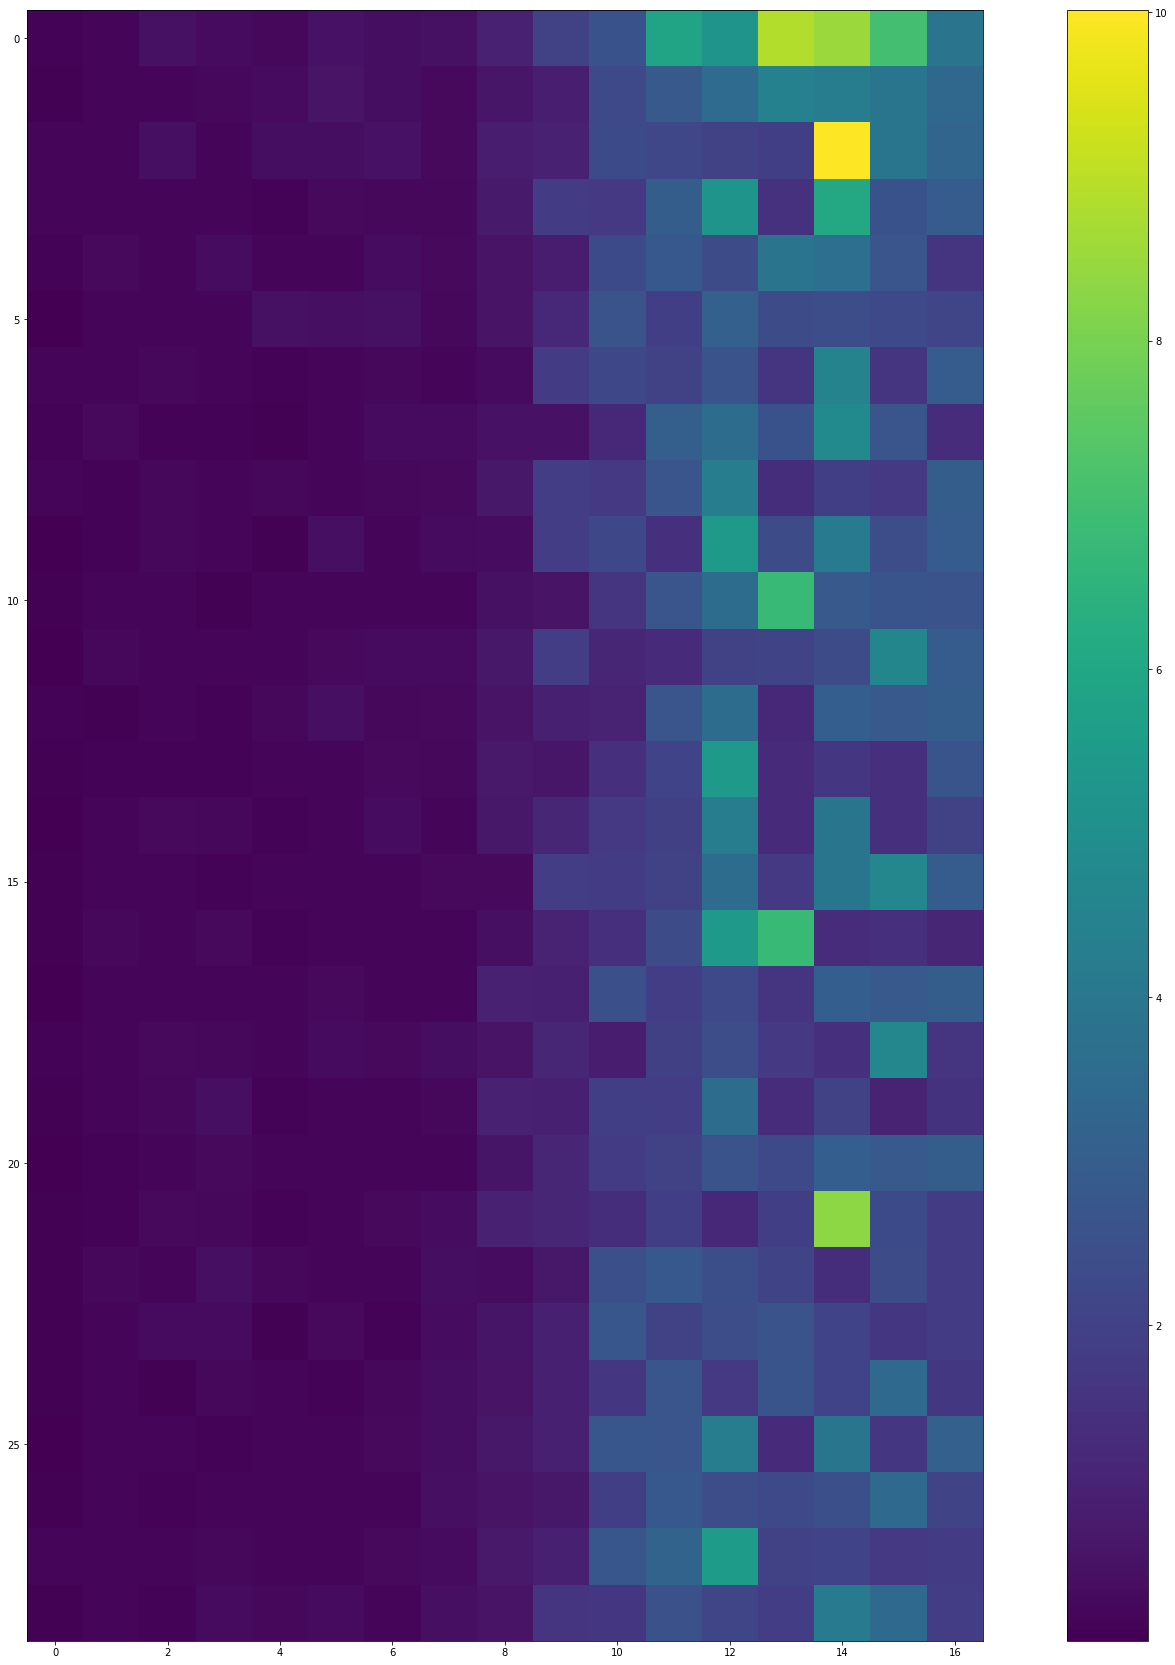

In [135]:
loss_max = np.max(loss, axis=0)
plt.imshow(loss_max)
plt.colorbar()
loss_max.shape

(29, 17)

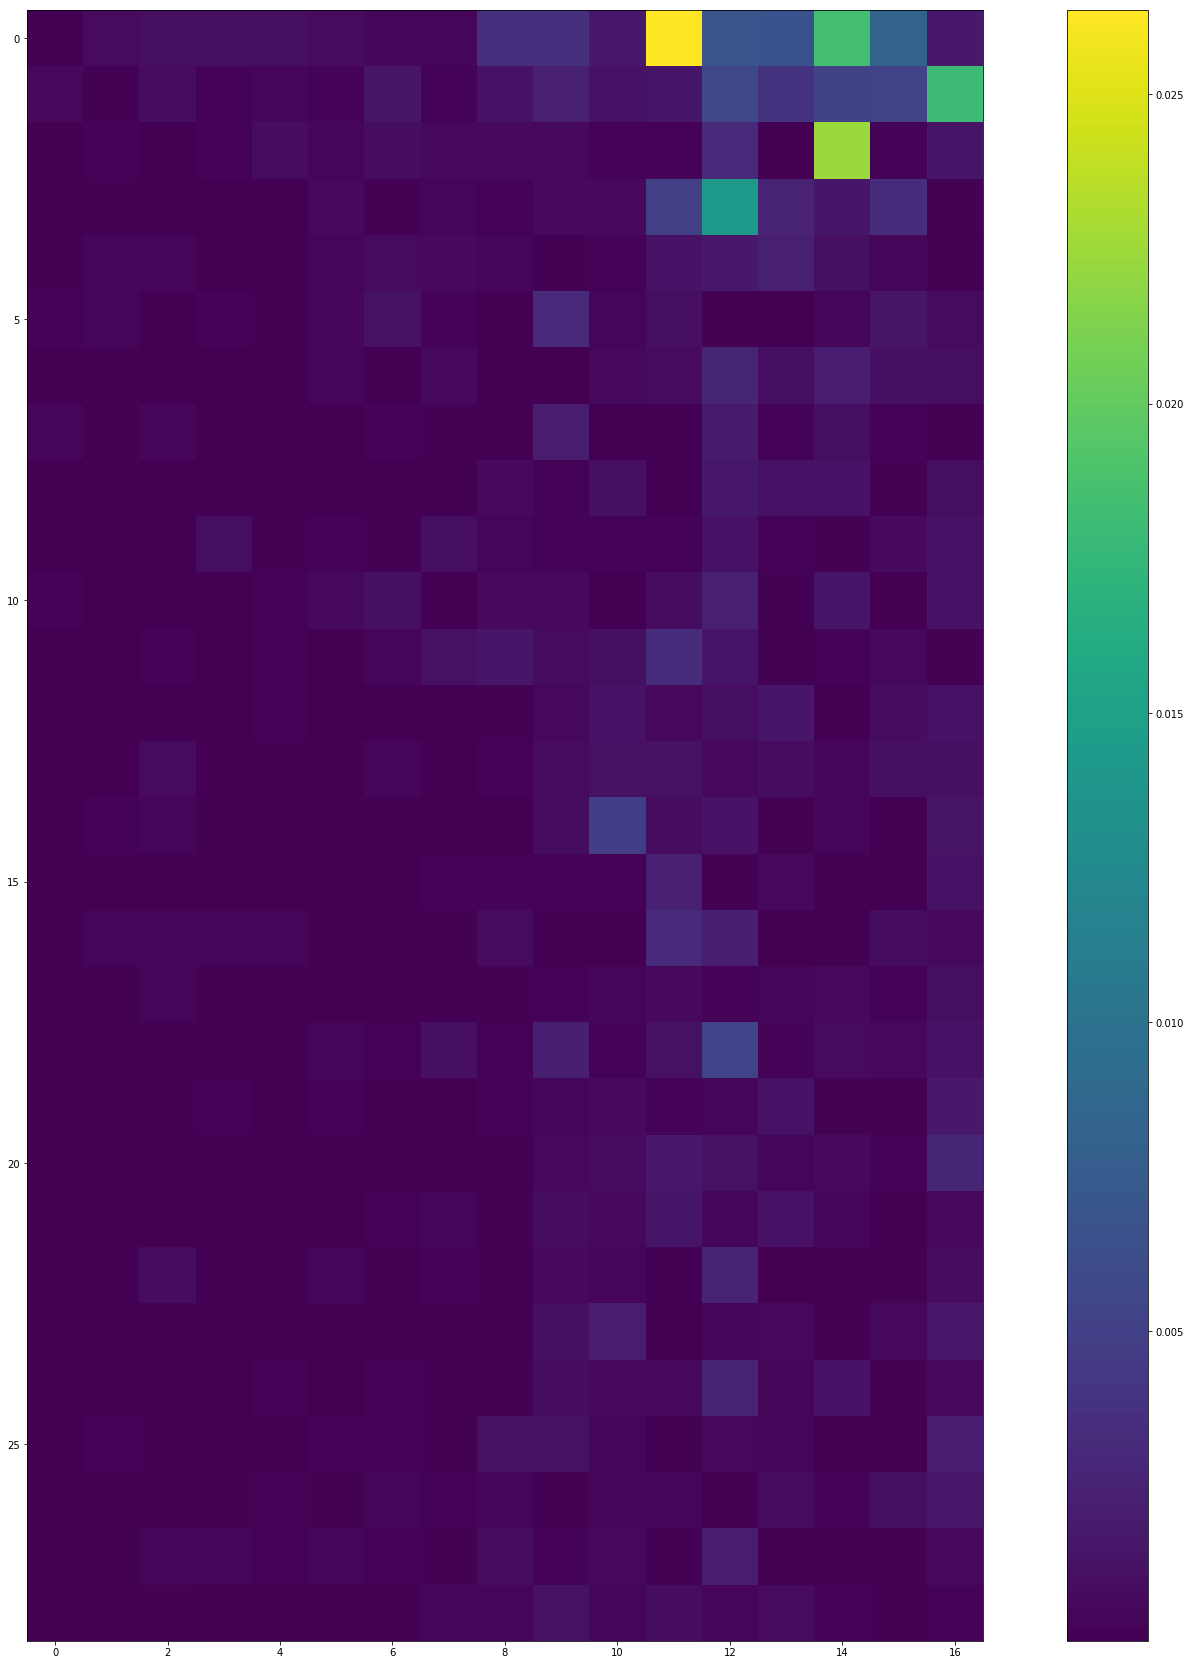

In [136]:
loss_min = np.min(loss, axis=0)
plt.imshow(loss_min)
plt.colorbar()
loss_min.shape

(29, 17)

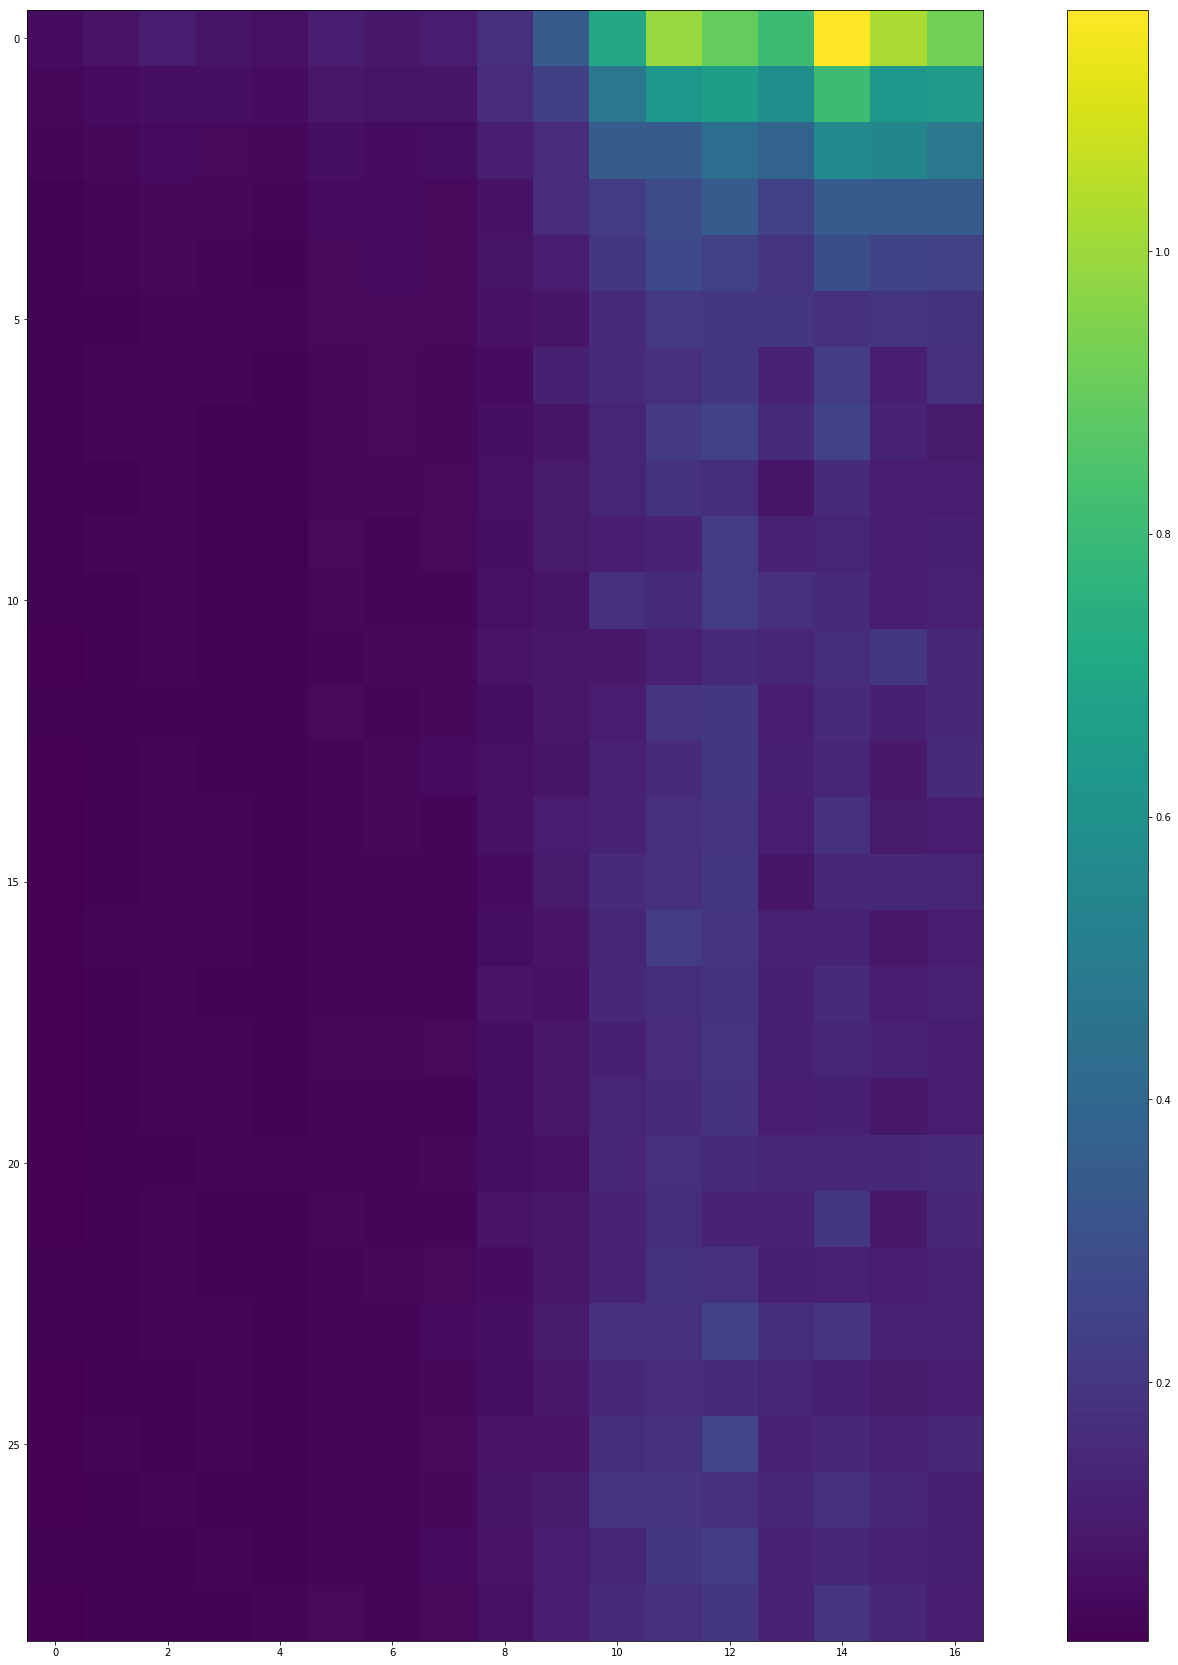

In [137]:
loss_mean = np.mean(loss, axis=0)
plt.imshow(loss_mean)
plt.colorbar()
loss_mean.shape

In [138]:
x = loss.mean(axis=(0, 2))
x.shape

(29,)

<BarContainer object of 29 artists>

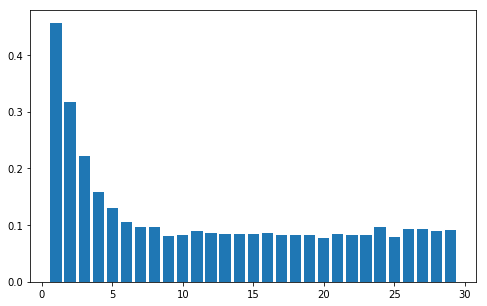

In [139]:
rc['figure.figsize'] = [8, 5]
plt.bar(range(1, len(x)+1), x)

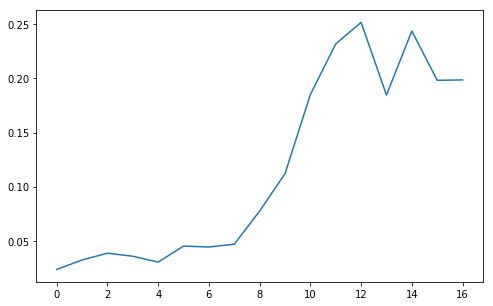

In [140]:
plt.plot(loss.mean(axis=(0, 1)))

## halfcheetah

In [228]:
loss = np.load("model_loss_50.npy")

In [229]:
loss.shape

(150, 29, 256)

In [230]:
x = loss.mean(axis=(0, 2))
x.shape

(29,)

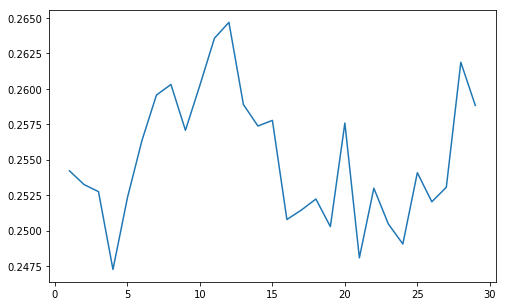

In [231]:
plt.plot(range(1, len(x)+1), x)

In [145]:
x = loss.mean(axis=(0, 1))
x.shape

(17,)

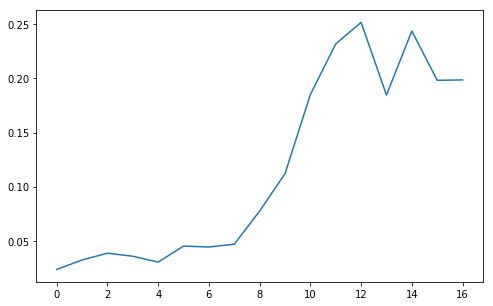

In [146]:
plt.plot(x)

In [174]:
loss = np.load("Q_loss_40.npy")
loss.shape

(150, 29, 1)

<BarContainer object of 29 artists>

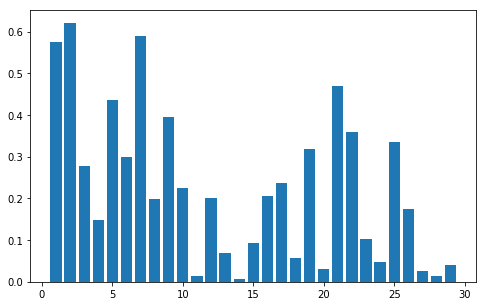

In [175]:
x = np.abs(loss.mean(axis=0)).flatten()
plt.bar(range(1, len(x)+1), x)

<BarContainer object of 29 artists>

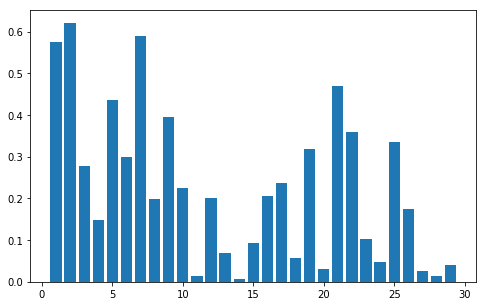

In [176]:
x = np.abs(loss.mean(axis=(0, 2)))
plt.bar(range(1, len(x)+1), x)

In [177]:
x.shape

(29,)

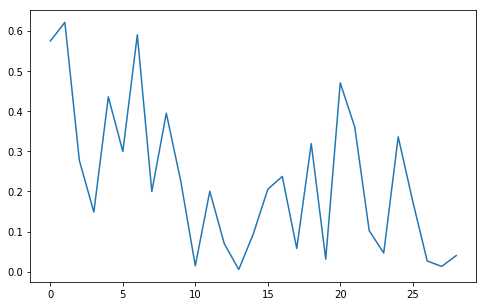

In [178]:
# x = loss.mean(axis=(0, 1))
plt.plot(x)

In [179]:
loss = np.load("model_loss_20.npy")
loss.shape

(150, 29, 256)

<BarContainer object of 29 artists>

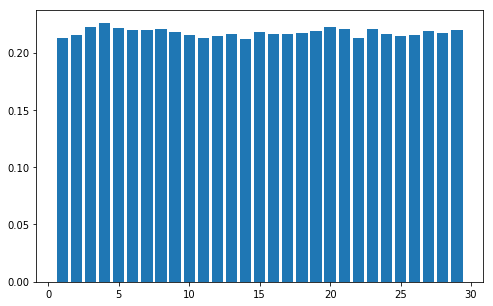

In [180]:
x = loss.mean(axis=(0, 2))
plt.bar(range(1, len(x)+1), x)

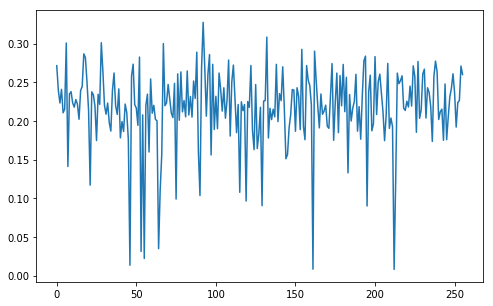

In [181]:
x = loss.mean(axis=(0, 1))
plt.plot(x)

## Analyse

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
rc['figure.figsize'] = [12, 5]
def analyse_model(loss):
    # print("loss_shape", loss.shape)
    plt.subplot(121)
    data_plot = loss.mean(axis=(0, 1))
    plt.plot(data_plot)
    plt.subplot(122)
    data_plot = loss.mean(axis=(0, 2))
    plt.plot(data_plot)
    
    # loss_mean = np.mean(loss, axis=0)   
    # plt.imshow(loss_mean)
    # plt.colorbar()

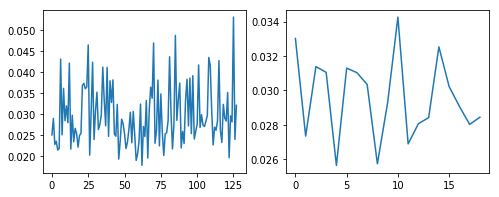

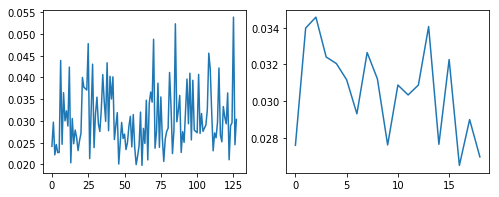

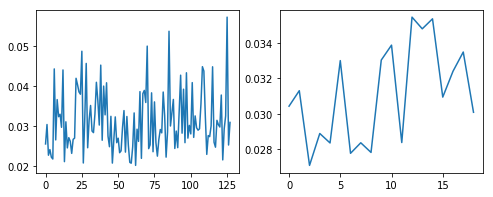

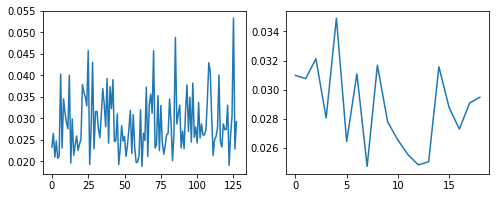

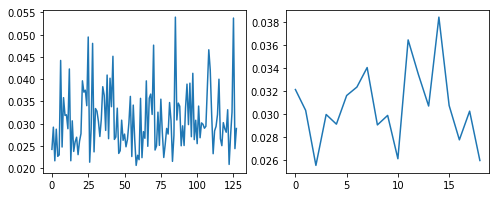

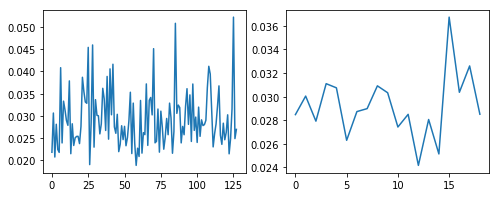

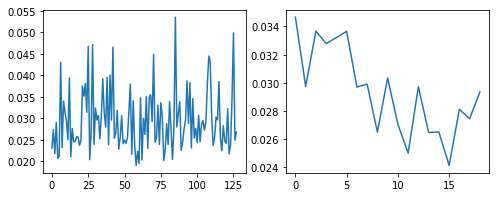

In [94]:
rc['figure.figsize'] = [8, 3]
for i in np.arange(650, 951, 50):
    plt.figure()
    loss = np.load("model__mq_loss_{}.npy".format(i))
    analyse_model(loss)

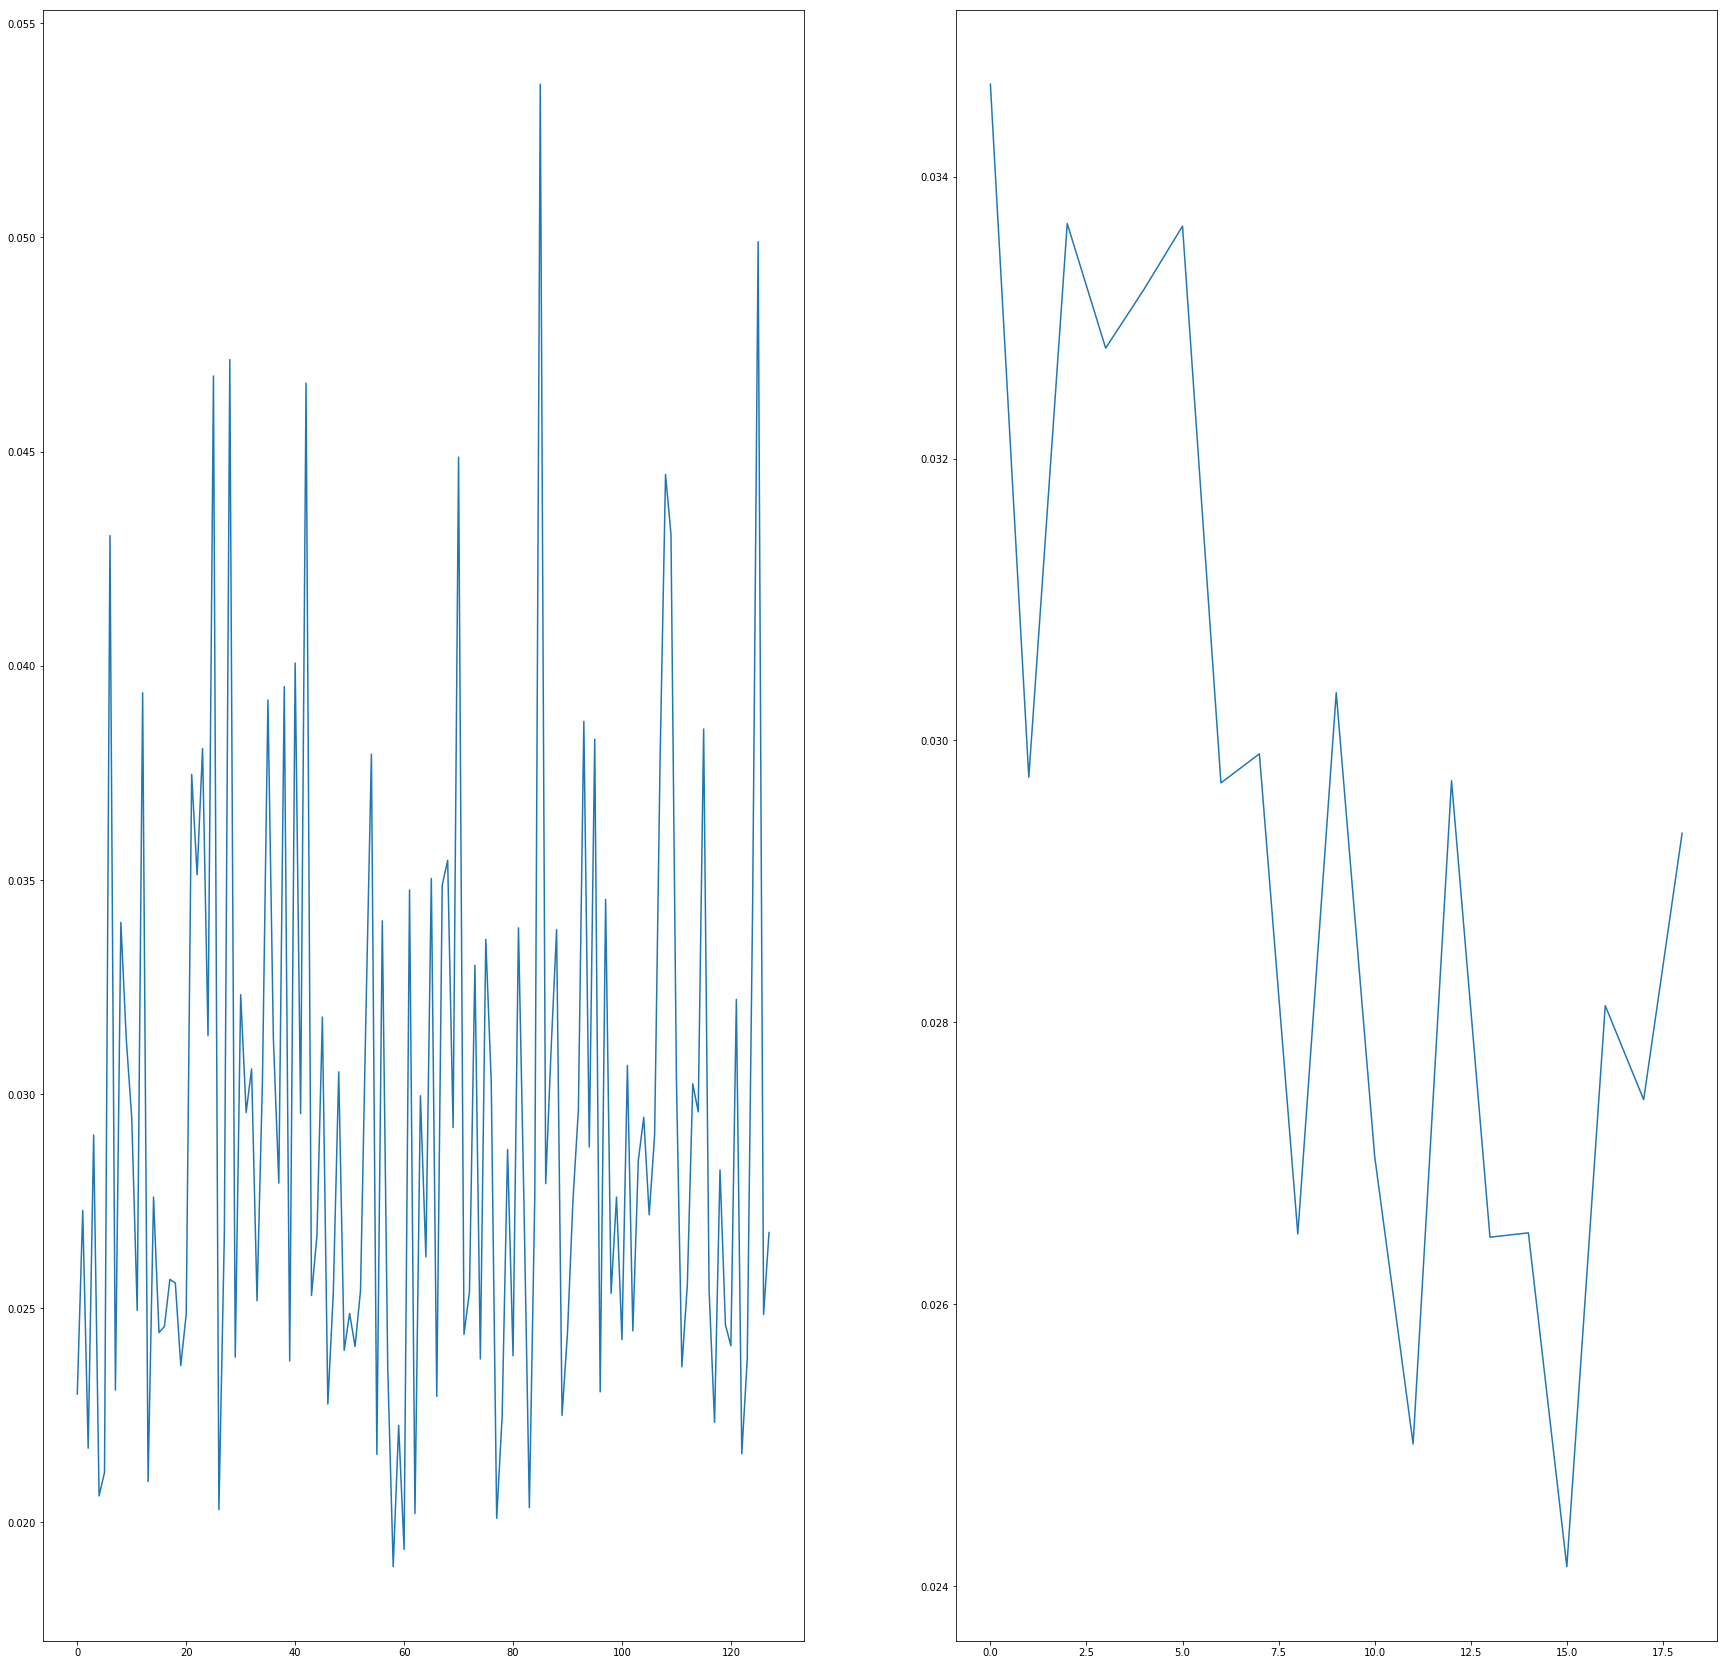

In [97]:
loss = np.load("model__mq_loss_950.npy")
analyse_model(loss)

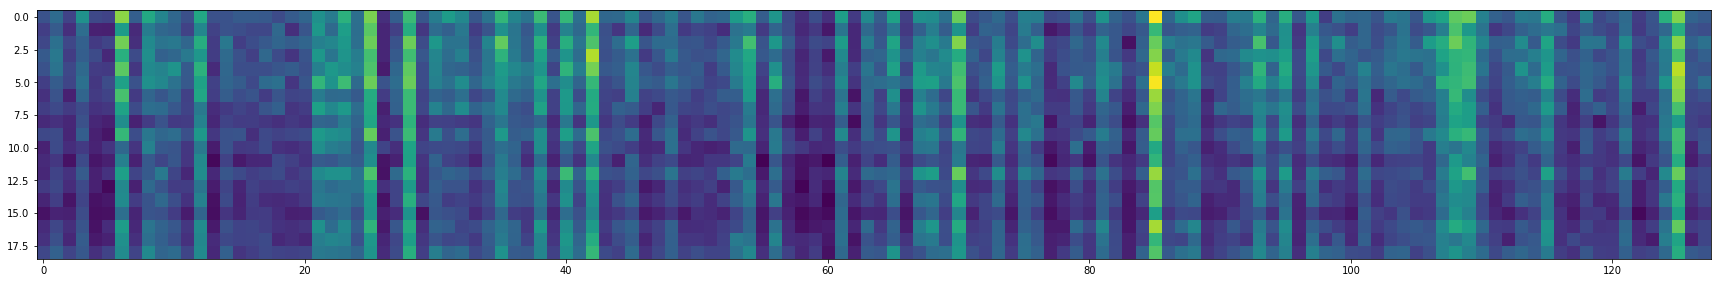

In [98]:
rc['figure.figsize'] = [30, 30]
plt.imshow(np.mean(loss, axis=0))

In [99]:
def analyse_value(x):
    # print("value_shape", x.shape)
    plt.figure()
    data_plot = x.mean(axis=(0, 2))
    plt.plot(data_plot)

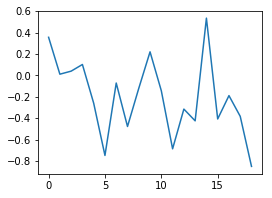

In [100]:
rc['figure.figsize'] = [4, 3]
q_value = np.load("Q_mq_loss_600.npy")
analyse_value(q_value)

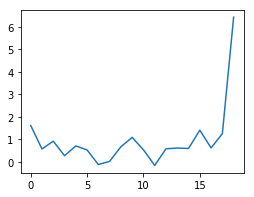

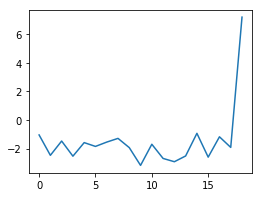

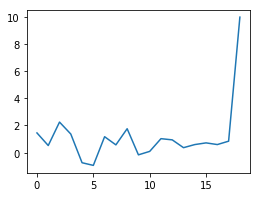

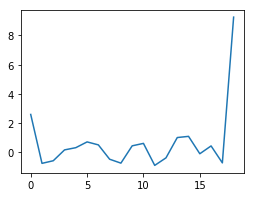

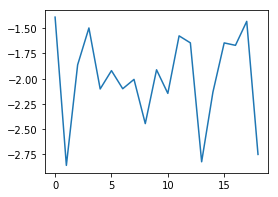

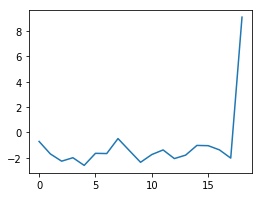

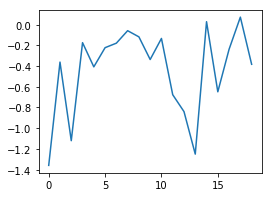

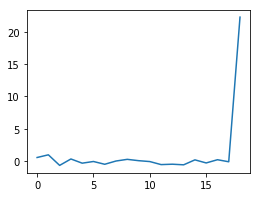

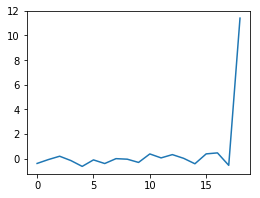

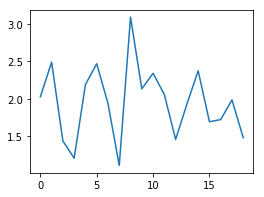

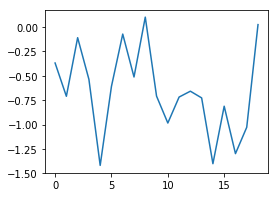

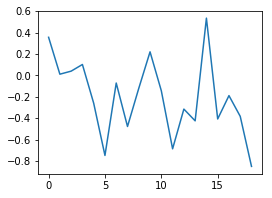

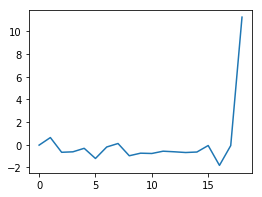

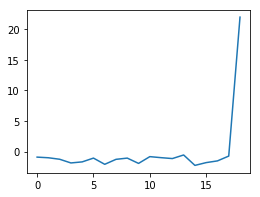

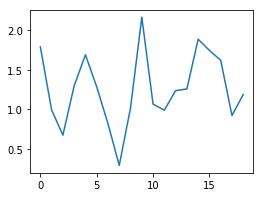

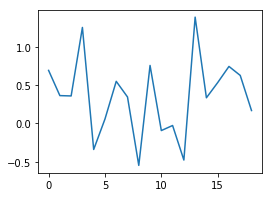

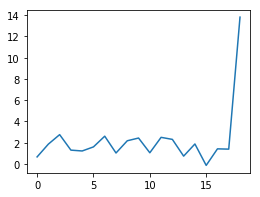

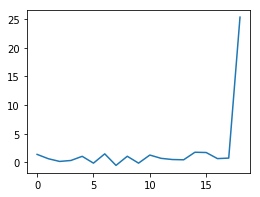

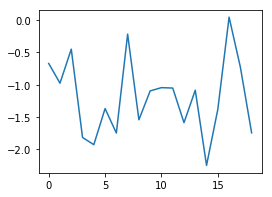

In [102]:
for i in np.arange(50, 951, 50):
    q_value = np.load("Q_mq_loss_{}.npy".format(i))
    analyse_value(q_value)

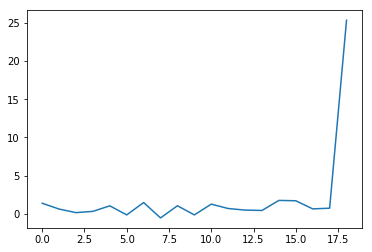

In [106]:
rc['figure.figsize'] = [6, 4]
q_value = np.load("Q_mq_loss_{}.npy".format(900))
analyse_value(q_value)

In [108]:
q_value.shape

(150, 19, 1)

In [110]:
x = np.mean(q_value, axis=0)
x.shape

(19, 1)

<BarContainer object of 19 artists>

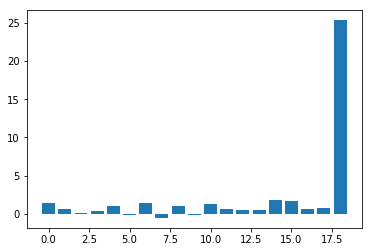

In [115]:
plt.bar(range(19), x.flatten())

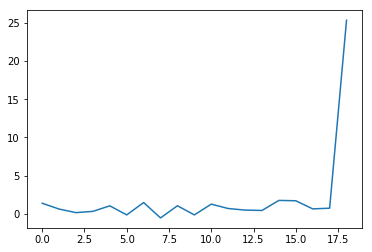

In [114]:
plt.plot(x)